<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Calculate_Stylized_Morphology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neuronal dendrites/trunks can have varying lengths, thickness, and branching. How can we approximate these compartments in a stylized model?

This Notebook analyzes every individual path from soma to terminal end of a basal dendrite and every path from end of the trunk to terminal ends of apical dendrites. By separating branching dendrites into individual paths we can help ourselves approximate a branching dendrite into a single linear path, while accounting for the changes in thickness of these branches.

With our dendrites separated into individual paths, we can calculate the average path length, and use that as our average dendrite length.

How should we approximate radius? We shouldn't use radius as a direct function of length because the length of dendrites may vary. It would be hard to choose a length if we use the average radii at a certain length along the path when paths may vary in length, and we would not want to neglect the important ends of dendrites where the radius may be significantly different.

To solve this issue, we should first calculate radius as a function of normalized pathlength. This allows us to view radius as it should change along our already approximated dendrite length.

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Stylized-ReducedOrder-L5-Model/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Stylized-ReducedOrder-L5-Model


In [3]:
output_folder = 'Detailedoutput_control'
segs = pd.read_csv('Detailedoutput_control/DetailedSegments.csv') # read segment values

In [4]:
segs.head() # visualize columns

,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,Section_diam,Section_nseg,Section_Ra,Coord X,Coord Y,Coord Z,ParentSegID,Elec_distance
0,0,0,4.633872,9.290377,0.1,soma,0,2.316936,23.169362,17.526643,5,100.0,-9.249733,-0.577674,0.0,NaN,0.998333
1,1,0,4.633872,15.657015,0.3,soma,0,6.950809,23.169362,17.526643,5,100.0,-4.624868,-0.288877,0.0,0.0,0.999377
2,2,0,4.633872,17.526643,0.5,soma,0,11.584681,23.169362,17.526643,5,100.0,-0.000010,0.000021,0.0,1.0,1.000000
3,3,0,4.633872,15.446328,0.7,soma,0,16.218553,23.169362,17.526643,5,100.0,4.624854,0.288824,0.0,2.0,0.999389
4,4,0,4.633872,9.437299,0.9,soma,0,20.852426,23.169362,17.526643,5,100.0,9.249712,0.577722,0.0,3.0,0.998310


In [5]:
#Get Columns
segIDs=segs['segmentID']
# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index() #not sure what this does
segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'
AllSegXCoord=segs['Coord X']
AllSegYCoord=segs['Coord Y']
AllSegZCoord=segs['Coord Z']
AllSegSec_ID=segs['Sec ID']
AllSegSec_name=segs['Type']
segLs=segs["Seg_L"]
segxs=segs["X"]
segdists=segs["Distance"]
SegSecL=segs["Section_L"]
segdiams=segs["Seg_diam"]
SegSecnseg=segs["Section_nseg"]
secRas=segs["Section_Ra"]
psegIDs=segs["ParentSegID"]
secids=segs["Sec ID"]
bmtkid=segs["BMTK ID"]
sectypes=segs["Type"]

psegids=[]
for i in range(len(psegIDs)):
  if np.isnan(psegIDs[i]) == False:
    psegids.append(int(psegIDs[i]))
  else:
    psegids.append(psegIDs[i])

In [6]:
probes=[]
class probe():
  def __init__(self,seg,sectionindex,sectionname,color,XCoord,YCoord,ZCoord,secRa,segdiam,segx,segdist,sectionL,sectionNseg,segL,parentseg,sectype):
    self.seg=seg
    self.sectionindex=sectionindex
    self.sectionname=sectionname
    self.color=color
    self.XCoord=XCoord
    self.YCoord=YCoord
    self.ZCoord=ZCoord
    self.secRa=secRa
    self.segdiam=segdiam
    self.x=segx
    self.segdist=segdist
    self.secL=sectionL
    self.secnseg=sectionNseg
    self.segL=segL
    self.name='sec:'+str(self.sectionname)+str(self.sectionindex)+' seg:'+str(self.seg)
    self.adjprobes=[]
    self.parentprobe=[]
    self.childprobes=[]
    self.axialcurrents=[]
    self.parentaxialcurrent=[]
    self.childrenaxialcurrents=[]
    self.halfsegRa=.01*self.secRa*(self.secL/2/self.secnseg)/(np.pi*(self.segdiam/2)**2)
    self.parentseg=parentseg
    self.sectype=sectype

    # try:
    #   self.axial_current=[Record_Axial_Current(section,single_seg=True)]
    # except:
    #   print(section)
for i in range(len(segIDs)):
  newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color='r',XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                parentseg=psegids[i],sectype=sectypes[i])
  probes.append(newprobe)

In [7]:
#getting adjacent segments using parent segment IDs
#getting children segments
for i in range(len(psegids)): #iterate through segment index
  if np.isnan(psegids[i]) == False:
    for seg in segIDs: #check segIDs
      if psegids[i]==seg: #find parent seg from parent seg id
        probes[seg].adjprobes.append(probes[i]) #add child probe to probe's adjprobe list
        probes[seg].childprobes.append(probes[i]) #add child probe to probe's childprobe list
#getting parent segment
for i in range(len(segIDs)):
  if np.isnan(psegids[i]) == False:
    probes[i].adjprobes.append(probes[int(psegids[i])]) #add parent seg probe to adj probes
    probes[i].parentprobe.append(probes[int(psegids[i])]) #add parent seg probe to parent probes

In [8]:
#find terminal ends
terminalprobes=[] #list of terminal segment probe objects
terminalbasalprobes=[]
terminalapicprobes=[]
terminalaxonprobes=[]
for probe in probes:
  if probe.seg not in psegids:
    terminalprobes.append(probe)
    if probe.sectype=='dend':
      terminalbasalprobes.append(probe) #find basal terminal points
    elif probe.sectype=='apic':
      terminalapicprobes.append(probe)
    elif probe.sectype=='axon':
      terminalaxonprobes.append(probe)

print(len(terminalprobes))

103


In [9]:
firstsegs = [] #list of segment indices for each section's first segment
sections=[] #list of already seen section ids for getting unique section

for i in range(len(bmtkid)):
    if bmtkid[i] not in sections: #make sure secid is unique
      sections.append(bmtkid[i]) #add unique secid to list of already seen secids
      firstsegs.append(segIDs[i]) #get a list of first segment by unique section id

print('firstsegs:',firstsegs)

firstsegs: [0, 5, 10, 13, 44, 45, 64, 103, 130, 135, 138, 141, 156, 157, 162, 191, 218, 227, 230, 231, 238, 243, 244, 249, 258, 259, 262, 267, 274, 287, 322, 327, 332, 351, 370, 387, 390, 421, 432, 447, 460, 479, 498, 505, 508, 513, 530, 559, 560, 561, 572, 575, 576, 587, 588, 593, 614, 615, 626, 629, 654, 685, 702, 719, 740, 745, 750, 755, 782, 803, 814, 835, 870, 875, 914, 917, 940, 945, 958, 967, 976, 979, 992, 997, 1024, 1027, 1036, 1049, 1054, 1063, 1064, 1065, 1068, 1073, 1082, 1113, 1130, 1131, 1154, 1185, 1198, 1201, 1204, 1239, 1260, 1293, 1302, 1307, 1314, 1319, 1324, 1331, 1334, 1335, 1338, 1353, 1368, 1371, 1372, 1397, 1410, 1431, 1480, 1535, 1552, 1561, 1602, 1603, 1612, 1617, 1634, 1649, 1654, 1655, 1658, 1683, 1696, 1739, 1762, 1801, 1802, 1803, 1806, 1809, 1812, 1813, 1860, 1895, 1902, 1935, 1956, 1959, 1964, 2003, 2022, 2051, 2060, 2071, 2078, 2091, 2098, 2113, 2140, 2169, 2192, 2207, 2212, 2215, 2222, 2237, 2246, 2263, 2280, 2311, 2312, 2321, 2322, 2325, 2330, 2351, 2

In [10]:
#use plot to find nexus branching points manually
nexusprobes=[probes[firstsegs[-61]].parentprobe[0]] #check parentseg()'s by guessing where to index

#Basal Dendrites

In [11]:
# define proportions for sectioning (should sum to 1)
prox_prop = 0.2
mid_prop = 0.3
dist_prop = 0.5

#Compute dendrites values
radii=[] # list of radii
dendrite_lengths=[] #list of dendrite lengths
prox_r=[]
mid_r=[]
dist_r=[]
prox_weights=[]
mid_weights=[]
dist_weights=[]
basalprobes=[] #list of basal probes
for terminalprobe in terminalbasalprobes:
  dendrite_length=terminalprobe.segdist
  dendrite_lengths.append(dendrite_length) #get length of dendrite
  thisprobe=terminalprobe
  while thisprobe.sectype!='soma':
    if (thisprobe not in basalprobes):
      basalprobes.append(thisprobe)
    radius=thisprobe.segdiam/2
    seg_normalized_distance=thisprobe.segdist/dendrite_length
    weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
    if seg_normalized_distance<=prox_prop:
      prox_r.append(radius*weight) #weight radii
      prox_weights.append(weight)
    elif seg_normalized_distance<=(mid_prop+prox_prop):
      mid_r.append(radius*weight)
      mid_weights.append(weight)
    elif seg_normalized_distance<=(dist_prop+mid_prop+prox_prop):
      dist_r.append(radius*weight)
      dist_weights.append(weight)
    else:
      print('weird')

    thisprobe=thisprobe.parentprobe[0] #move toward soma
#finish weighted mean
mean_prox_r=np.sum(prox_r)/sum(prox_weights)
mean_mid_r=np.sum(mid_r)/np.sum(mid_weights)
mean_dist_r=np.sum(dist_r)/np.sum(dist_weights)

print('The mean dendrite length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
print('The proximal section length should be',prox_prop*np.mean(dendrite_lengths))
print('The middle section length should be',mid_prop*np.mean(dendrite_lengths))
print('The distal section length should be',dist_prop*np.mean(dendrite_lengths))
print('The mean proximal section radius is',mean_prox_r,'and std is',np.std(prox_r))
print('The mean middle section radius is',mean_mid_r,'and std is',np.std(mid_r))
print('The mean distal section radius is',mean_dist_r,'and std is',np.std(dist_r)) #standard deviation is not right

The mean dendrite length is 164.18000898247945 and std is 55.739131580787415
The proximal section length should be 32.83600179649589
The middle section length should be 49.25400269474383
The distal section length should be 82.09000449123972
The mean proximal section radius is 0.6676019297699011 and std is 0.0071169770469351025
The mean middle section radius is 0.42729734996124336 and std is 0.009953020440331563
The mean distal section radius is 0.24012652982922575 and std is 0.005702118700930382


#Trunk

In [12]:
# define proportions for sectioning (should sum to 1)

prox_prop=199.59284190985812/635.869529553687 #obliqueDistanceUpTrunk/trunklength #in the stylized model oblique dendrites will be attached to the end of proxtrunk
dist_prop = ((635.869529553687-199.59284190985812)/635.869529553687)/2 #in the stylized model disttrunk may have increased calcium conductances
mid_prop = 1-(dist_prop+prox_prop) #mid_prop will be remaining part

#Compute dendrites values
radii=[] # list of radii
dendrite_lengths=[] #list of dendrite lengths
prox_r=[]
mid_r=[]
dist_r=[]
prox_weights=[]
mid_weights=[]
dist_weights=[]
trunkprobes=[] #list for trunk segments
for terminalprobe in nexusprobes:
  dendrite_length=terminalprobe.segdist
  dendrite_lengths.append(dendrite_length) #get length of dendrite
  thisprobe=terminalprobe
  while thisprobe.sectype!='soma':
    trunkprobes.append(thisprobe)
    radius=thisprobe.segdiam/2
    seg_normalized_distance=thisprobe.segdist/dendrite_length
    weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
    if seg_normalized_distance<=prox_prop:
      prox_r.append(radius*weight) #weight radii
      prox_weights.append(weight)
    elif seg_normalized_distance<=(mid_prop+prox_prop):
      mid_r.append(radius*weight)
      mid_weights.append(weight)
    elif seg_normalized_distance<=(dist_prop+mid_prop+prox_prop):
      dist_r.append(radius*weight)
      dist_weights.append(weight)
    else:
      print('weird')
    thisprobe=thisprobe.parentprobe[0] #move toward soma

#finish weighted mean
mean_prox_r=np.sum(prox_r)/sum(prox_weights)
mean_mid_r=np.sum(mid_r)/np.sum(mid_weights)
mean_dist_r=np.sum(dist_r)/np.sum(dist_weights)

print('The mean trunk length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
print('The proximal section length should be',prox_prop*np.mean(dendrite_lengths))
print('The middle section length should be',mid_prop*np.mean(dendrite_lengths))
print('The distal section length should be',dist_prop*np.mean(dendrite_lengths))
print('The mean proximal section radius is',mean_prox_r,'and std is',np.std(prox_r))
print('The mean middle section radius is',mean_mid_r,'and std is',np.std(mid_r))
print('The mean distal section radius is',mean_dist_r,'and std is',np.std(dist_r)) #standard deviation is not right

The mean trunk length is 635.869529553687 and std is 0.0
The proximal section length should be 199.59284190985812
The middle section length should be 218.1383438219145
The distal section length should be 218.13834382191445
The mean proximal section radius is 1.785650799792007 and std is 0.005096733887141146
The mean middle section radius is 1.3142693738715931 and std is 0.0010080407201392986
The mean distal section radius is 1.3352037355371051 and std is 0.0006940065100590032


In [13]:
max(segs['Distance']) #how to pull a column after separating by type

1309.6110769281531

#Oblique Dendrite

##use multiple sections

In [14]:
# # define proportions for sectioning (should sum to 1)
# prox_prop = 0.2
# mid_prop = 0.3
# dist_prop = 0.5

# #Compute dendrites values
# radii=[] # list of radii
# dendrite_lengths=[] #list of dendrite lengths
# prox_r=[]
# mid_r=[]
# dist_r=[]
# prox_weights=[]
# mid_weights=[]
# dist_weights=[]
# obliqueprobes=[] #list for oblique segments
# obliquetrunkdists=[] # list for distance up the trunk

# for terminalprobe in terminalapicprobes:
#   if terminalprobe.segdist<nexusprobes[0].segdist: #this is an oblique dendrite
#     thisprobe=terminalprobe
#     while (thisprobe.sectype!='soma')and(thisprobe not in trunkprobes):#need to subtract the trunk's pathlength
#       thisprobe=thisprobe.parentprobe[0]
#     #arrived at trunkprobe
#     trunklength=thisprobe.segdist
#     dendrite_length=terminalprobe.segdist-trunklength
#     dendrite_lengths.append(dendrite_length) #add dendrite length to the list
#     thisprobe=terminalprobe #restart iteration through this dendrite
#     while thisprobe.sectype!='soma' and thisprobe not in trunkprobes:
#       if (thisprobe not in obliqueprobes):
#         obliqueprobes.append(thisprobe)
#       radius=thisprobe.segdiam/2
#       seg_normalized_distance=(thisprobe.segdist-trunklength)/dendrite_length
#       weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
#       if seg_normalized_distance<=prox_prop:
#         prox_r.append(radius*weight) #weight radii
#         prox_weights.append(weight)
#       elif seg_normalized_distance<=(mid_prop+prox_prop):
#         mid_r.append(radius*weight)
#         mid_weights.append(weight)
#       elif seg_normalized_distance<=(dist_prop+mid_prop+prox_prop):
#         dist_r.append(radius*weight)
#         dist_weights.append(weight)
#       else:
#         print('weird')
#       thisprobe=thisprobe.parentprobe[0] #move toward soma
#     #arrived at trunk segment
#     obliquetrunkdists.append(thisprobe.segdist)

# #calculate mean oblique length up the trunk
# meanproxtrunklength=np.mean(obliquetrunkdists)
# stdproxtrunklength=np.std(obliquetrunkdists)

# #finish weighted mean
# mean_prox_r=np.sum(prox_r)/sum(prox_weights)
# mean_mid_r=np.sum(mid_r)/np.sum(mid_weights)
# mean_dist_r=np.sum(dist_r)/np.sum(dist_weights)

# print('The mean dendrite length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
# print('The proximal section length should be',prox_prop*np.mean(dendrite_lengths))
# print('The middle section length should be',mid_prop*np.mean(dendrite_lengths))
# print('The distal section length should be',dist_prop*np.mean(dendrite_lengths))
# print('The mean proximal section radius is',mean_prox_r,'and std is',np.std(prox_r))
# print('The mean middle section radius is',mean_mid_r,'and std is',np.std(mid_r))
# print('The mean distal section radius is',mean_dist_r,'and std is',np.std(dist_r)) #standard deviation is not right
# print('The mean distance up the trunk is',meanproxtrunklength,'and std is',stdproxtrunklength) #standard deviation is not right

##use one section

In [15]:
#obliques will have only one section

#Compute dendrites values
radii=[] # list of radii
dendrite_lengths=[] #list of dendrite lengths
r=[]
weights=[]
obliqueprobes=[] #list for oblique segments
obliquetrunkdists=[] # list for distance up the trunk

for terminalprobe in terminalapicprobes:
  if terminalprobe.segdist<nexusprobes[0].segdist: #this is an oblique dendrite
    thisprobe=terminalprobe
    while (thisprobe.sectype!='soma')and(thisprobe not in trunkprobes):#need to subtract the trunk's pathlength
      thisprobe=thisprobe.parentprobe[0]
    #arrived at trunkprobe
    trunklength=thisprobe.segdist
    dendrite_length=terminalprobe.segdist-trunklength
    dendrite_lengths.append(dendrite_length) #add dendrite length to the list
    thisprobe=terminalprobe #restart iteration through this dendrite
    while thisprobe.sectype!='soma' and thisprobe not in trunkprobes:
      if (thisprobe not in obliqueprobes):
        obliqueprobes.append(thisprobe)
      radius=thisprobe.segdiam/2
      seg_normalized_distance=(thisprobe.segdist-trunklength)/dendrite_length
      weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
      r.append(radius*weight) #weight radii
      weights.append(weight)
      thisprobe=thisprobe.parentprobe[0] #move toward soma
    #arrived at trunk segment
    obliquetrunkdists.append(thisprobe.segdist)

#calculate mean oblique length up the trunk
meanproxtrunklength=np.mean(obliquetrunkdists)
stdproxtrunklength=np.std(obliquetrunkdists)

#finish weighted mean
mean_r=np.sum(r)/sum(weights)

print('The mean dendrite length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
print('The mean section radius is',mean_r,'and std is',np.std(prox_r))
print('The mean distance up the trunk is',meanproxtrunklength,'and std is',stdproxtrunklength) #standard deviation is not right

The mean dendrite length is 131.5842133738954 and std is 46.86021982606098
The mean section radius is 0.3790173552235297 and std is 0.005096733887141146
The mean distance up the trunk is 199.59284190985812 and std is 87.52090332781046


#Tuft Dendrites

In [16]:
# define proportions for sectioning (should sum to 1)
prox_prop = (685-635.869529553687)/553.6277168823119  #prox tuft does not have increased calcium conductance
mid_prop = (885-685)/553.6277168823119 #increased calcium conductance range
dist_prop = 1-(mid_prop+prox_prop)

#Compute dendrites values
radii=[] # list of radii
dendrite_lengths=[] #list of dendrite lengths
prox_r=[]
mid_r=[]
dist_r=[]
prox_weights=[]
mid_weights=[]
dist_weights=[]
tuftprobes=[] #list for tuft segments

for terminalprobe in terminalapicprobes:
  if terminalprobe.segdist>nexusprobes[0].segdist: #this is a tuft dendrite
    thisprobe=terminalprobe
    while ((thisprobe.sectype!='soma')and(thisprobe not in trunkprobes)):#need to subtract the trunk's pathlength
      thisprobe=thisprobe.parentprobe[0]
    #arrived at trunkprobe
    trunklength=thisprobe.segdist
    dendrite_length=terminalprobe.segdist-trunklength
    dendrite_lengths.append(dendrite_length)
    thisprobe=terminalprobe #restart iteration through this dendrite
    while ((thisprobe.sectype!='soma')and(thisprobe not in trunkprobes)):
      if (thisprobe not in tuftprobes):
        tuftprobes.append(thisprobe)
      radius=thisprobe.segdiam/2
      seg_normalized_distance=(thisprobe.segdist-trunklength)/dendrite_length
      weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
      if seg_normalized_distance<=prox_prop:
        prox_r.append(radius*weight) #weight radii
        prox_weights.append(weight)
      elif seg_normalized_distance<=(mid_prop+prox_prop):
        mid_r.append(radius*weight)
        mid_weights.append(weight)
      elif seg_normalized_distance<=(dist_prop+mid_prop+prox_prop):
        dist_r.append(radius*weight)
        dist_weights.append(weight)
      else:
        print('weird')
      thisprobe=thisprobe.parentprobe[0] #move toward soma

#finish weighted mean
mean_prox_r=np.sum(prox_r)/sum(prox_weights)
mean_mid_r=np.sum(mid_r)/np.sum(mid_weights)
mean_dist_r=np.sum(dist_r)/np.sum(dist_weights)

print('The mean dendrite length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
print('The proximal section length should be',prox_prop*np.mean(dendrite_lengths))
print('The middle section length should be',mid_prop*np.mean(dendrite_lengths))
print('The distal section length should be',dist_prop*np.mean(dendrite_lengths))
print('The mean proximal section radius is',mean_prox_r,'and std is',np.std(prox_r))
print('The mean middle section radius is',mean_mid_r,'and std is',np.std(mid_r))
print('The mean distal section radius is',mean_dist_r,'and std is',np.std(dist_r)) #standard deviation is not right

The mean dendrite length is 553.6277168823119 and std is 99.15988957740672
The proximal section length should be 49.130470446312984
The middle section length should be 200.0
The distal section length should be 304.4972464359989
The mean proximal section radius is 0.8999999761581434 and std is 0.0015882612881562826
The mean middle section radius is 0.6484952311610834 and std is 0.0022828901151911484
The mean distal section radius is 0.3898439647982608 and std is 0.0018916712389856131


#Axon

In [17]:
#axon will be one section

#Compute dendrites values
radii=[] # list of radii
dendrite_lengths=[] #list of dendrite lengths
r=[] #list of weighted radii
weights=[]
axonprobes=[] #list of axon probes
for terminalprobe in terminalaxonprobes:
  dendrite_length=terminalprobe.segdist
  dendrite_lengths.append(dendrite_length) #get length of dendrite
  thisprobe=terminalprobe
  while thisprobe.sectype!='soma':
    if (thisprobe not in axonprobes):
      axonprobes.append(thisprobe)
    radius=thisprobe.segdiam/2
    seg_normalized_distance=thisprobe.segdist/dendrite_length
    weight=thisprobe.segL/dendrite_length #since segments have various lengths, longer segments may need to have more impact on calculation
    r.append(radius*weight) #weight radii
    weights.append(weight)
    thisprobe=thisprobe.parentprobe[0] #move toward soma
#finish weighted mean
mean_r=np.sum(r)/sum(weights)

print('The mean dendrite length is',np.mean(dendrite_lengths),'and std is',np.std(dendrite_lengths))
print('The mean radius is',mean_r,'and std is',np.std(prox_r))

The mean dendrite length is 69.4418239164229 and std is 0.0
The mean radius is 0.5000000000000001 and std is 0.0015882612881562826


#Analyze Plot
Shows that the segments have been correctly classified

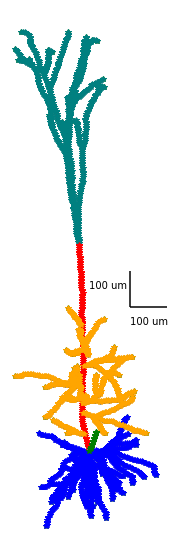

In [18]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

# for i in firstsegs:
#   plt.plot(AllSegXCoord[probes[i].seg],
#          AllSegYCoord[probes[i].seg],
#          '*',color=probes[i].color)
  # for j in range(len(probes[i].adjprobes)):
  #     plt.plot(AllSegXCoord[probes[i].adjprobes[j].seg],
  #         AllSegYCoord[probes[i].adjprobes[j].seg],
  #         '*',color='blue')

# nexus=[probes[firstsegs[-51]].parentprobe[0],probes[firstsegs[-61]].parentprobe[0]] #check parentseg()'s by guessing where to index
nexus=[probes[firstsegs[-61]].parentprobe[0]]
# adjp=[0] #indexes childprobes of nexus probes to find the adjacent
for probe in nexus:
  plt.plot(AllSegXCoord[probe.seg],
         AllSegYCoord[probe.seg],
         '*',color='m')
  # see all adj probes
  # for j in range(len(probes[].adjprobes)):
  #   plt.plot(AllSegXCoord[probes[].adjprobes[j].seg],
  #       AllSegYCoord[probes[psegs[i]].adjprobes[j].seg],
  #       '*',color='blue')
#see child probes
  for j in range(len(probes[i].childprobes)):
      plt.plot(AllSegXCoord[probes[i].childprobes[j].seg],
          AllSegYCoord[probes[i].childprobes[j].seg],
          '*',color='orange')
#see parent probes      
  # for j in range(len(probes[i].parentprobe)):
  #     plt.plot(AllSegXCoord[probes[i].parentprobe[j].seg],
  #         AllSegYCoord[probes[i].parentprobe[j].seg],
  #         '*',color='blue')
#see terminal probes      
for j in range(len(terminalprobes)):
    plt.plot(AllSegXCoord[terminalprobes[j].seg],
        AllSegYCoord[terminalprobes[j].seg],
        '*',color='green')
# work in progress
# see basal probes      
for j in range(len(basalprobes)):
    plt.plot(AllSegXCoord[basalprobes[j].seg],
        AllSegYCoord[basalprobes[j].seg],
        '*',color='blue')
# see tuft probes
for j in range(len(tuftprobes)):
    plt.plot(AllSegXCoord[tuftprobes[j].seg],
        AllSegYCoord[tuftprobes[j].seg],
        '*',color='teal')
# see trunk probes
for j in range(len(trunkprobes)):
    plt.plot(AllSegXCoord[trunkprobes[j].seg],
        AllSegYCoord[trunkprobes[j].seg],
        '*',color='red')
# see oblique probes
for j in range(len(obliqueprobes)):
    plt.plot(AllSegXCoord[obliqueprobes[j].seg],
        AllSegYCoord[obliqueprobes[j].seg],
        '*',color='orange')
# see axon probes
for j in range(len(axonprobes)):
    plt.plot(AllSegXCoord[axonprobes[j].seg],
        AllSegYCoord[axonprobes[j].seg],
        '*',color='green')

#see nexus probes